In [58]:
import pandas as pd
import numpy as np


In [ ]:
df_merged = pd.read_csv('https://raw.githubusercontent.com/McNickSisto/world_data_league/main/stage_final/data/Noise_weather_wifi_sim_holidays_opencount_complaints_logvalues.csv')
df_merged = df_merged.drop(columns=['Unnamed: 0'])
df_merged.sample(4)

,C1,C2,C3,C4,C5,date_hour,No. of Visitors,index,cluster,data_a,numero_presenze,layer_id,layer_nome,dettaglio(secondi),temp,winds,rainfall_mm,snowfall_mm,Holiday,isHoliday,date,hour,day,Log_Avg,Complaints_no,count_close,count_open
11067,61.4,61.1,61.5,63.4,66.8,06-07-18 19:00,NaN,746.0,Consumer,2018-06-07T20:00:00Z,3394.0,5491d6d2-0c9e-47b7-bfde-c84c632efacc,Area 1,3600.0,16.65,NaN,1.581,15.933333,NaN,0,2018-07-06,19,4,63.445979,4.0,6.0,108.0
7224,62.4,60.5,61.9,62.5,63.3,24-03-18 19:00,NaN,193.0,Maschi,2018-03-24T20:00:00Z,2093.0,5491d6d2-0c9e-47b7-bfde-c84c632efacc,Area 1,3600.0,6.22,NaN,-0.002,9.100000,NaN,0,2018-03-24,19,5,62.214078,5.0,NaN,102.0
15249,67.6,60.9,74.2,63.7,62.9,10-07-18 02:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.22,NaN,0.035,9.700000,NaN,0,2018-07-10,2,1,68.760032,0.0,6.0,NaN
2744,60.6,60.8,61.7,61.0,64.2,20-01-18 12:00,NaN,2554.0,Pendolari,2018-01-20T13:00:00Z,236.0,5491d6d2-0c9e-47b7-bfde-c84c632efacc,Area 1,3600.0,9.07,NaN,0.003,9.200000,NaN,0,2018-01-20,12,5,61.885753,0.0,NaN,72.0


For now let us consider log_avg (logarithmic average of C1, C2, C3, C4, C5), temp, rainfall, snowfall, isholiday, complaints_no, count_close, count_open

In [79]:
df_reg_1 = df_merged[['date_hour', 'temp', 'winds', 'rainfall_mm', 'snowfall_mm', 'isHoliday', 'date', 'hour', 'day', 'Log_Avg', 'Complaints_no', 'count_close']]
df_reg_1 = df_reg_1.fillna(value={'count_close' : 0, 'winds' : 0, 'snowfall_mm':0 , 'rainfall_mm' : 0})
df_reg_1['date_hour'] = pd.to_datetime(df_reg_1['date_hour'])
df_reg_1 =  df_reg_1.set_index('date_hour')
df_reg_1

,temp,winds,rainfall_mm,snowfall_mm,isHoliday,date,hour,day,Log_Avg,Complaints_no,count_close
date_hour,,,,,,,,,,,
2018-01-01 00:00:00,1.04,0.366667,-0.010,2.600000,1,2018-01-01,0,0,70.253908,0.0,66.0
2018-01-01 01:00:00,1.09,0.590000,0.009,2.600000,1,2018-01-01,1,0,65.415954,0.0,6.0
2018-01-01 02:00:00,1.05,0.450000,0.008,2.266667,1,2018-01-01,2,0,61.341179,0.0,12.0
2018-01-01 03:00:00,0.89,0.400000,0.006,2.266667,1,2018-01-01,3,0,64.066780,0.0,6.0
2018-01-01 04:00:00,0.73,0.780000,-0.011,2.300000,1,2018-01-01,4,0,63.174985,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00,5.27,0.000000,0.002,4.200000,1,2018-12-31,19,0,60.809809,0.0,0.0
2018-12-31 20:00:00,4.99,0.000000,0.001,3.633333,1,2018-12-31,20,0,60.867939,0.0,0.0
2018-12-31 21:00:00,4.53,0.000000,0.011,2.600000,1,2018-12-31,21,0,59.746766,0.0,0.0


In [80]:
df_reg_1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17311 entries, 2018-01-01 00:00:00 to 2018-12-31 23:00:00
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   temp           17311 non-null  float64
 1   winds          17311 non-null  float64
 2   rainfall_mm    17311 non-null  float64
 3   snowfall_mm    17311 non-null  float64
 4   isHoliday      17311 non-null  int64  
 5   date           17311 non-null  object 
 6   hour           17311 non-null  int64  
 7   day            17311 non-null  int64  
 8   Log_Avg        17311 non-null  float64
 9   Complaints_no  17311 non-null  float64
 10  count_close    17311 non-null  float64
dtypes: float64(7), int64(3), object(1)
memory usage: 1.6+ MB


In [81]:
cor = df_reg_1.corr()

In [82]:
cor['Log_Avg'].sort_values()

Complaints_no   -0.010231
winds            0.010214
isHoliday        0.029025
temp             0.077758
rainfall_mm      0.085956
snowfall_mm      0.092939
day              0.144505
count_close      0.152374
hour             0.353521
Log_Avg          1.000000
Name: Log_Avg, dtype: float64

In [83]:
df_close = df_reg_1.copy()

In [84]:
def create_regressor_attributes(df, attribute, list_of_prev_t_instants) :
    
    list_of_prev_t_instants.sort()
    start = list_of_prev_t_instants[-1] 
    end = len(df)
    df['datetime'] = df.index
    df.reset_index(drop=True)

    df_copy = df[start:end]
    df_copy.reset_index(inplace=True, drop=True)

    for attribute in attribute :
            foobar = pd.DataFrame()

            for prev_t in list_of_prev_t_instants :
                new_col = pd.DataFrame(df[attribute].iloc[(start - prev_t) : (end - prev_t)])
                new_col.reset_index(drop=True, inplace=True)
                new_col.rename(columns={attribute : '{}_(t-{})'.format(attribute, prev_t)}, inplace=True)
                foobar = pd.concat([foobar, new_col], sort=False, axis=1)

            df_copy = pd.concat([df_copy, foobar], sort=False, axis=1)
            
    df_copy.set_index(['datetime'], drop=True, inplace=True)
    return df_copy

In [85]:
list_of_attributes = ['Log_Avg']

list_of_prev_t_instants = []
for i in range(24,241,24):
    list_of_prev_t_instants.append(i)

list_of_prev_t_instants

[24, 48, 72, 96, 120, 144, 168, 192, 216, 240]

In [86]:
df_new = create_regressor_attributes(df_close, list_of_attributes, list_of_prev_t_instants)
df_new.head()

,temp,winds,rainfall_mm,snowfall_mm,isHoliday,date,hour,day,Log_Avg,Complaints_no,count_close,Log_Avg_(t-24),Log_Avg_(t-48),Log_Avg_(t-72),Log_Avg_(t-96),Log_Avg_(t-120),Log_Avg_(t-144),Log_Avg_(t-168),Log_Avg_(t-192),Log_Avg_(t-216),Log_Avg_(t-240)
datetime,,,,,,,,,,,,,,,,,,,,,
2018-01-11 00:00:00,3.86,0.516667,0.001667,5.200000,0,2018-11-01,0,3,60.279681,0.0,60.0,58.236836,64.298257,60.211272,67.974778,64.172940,58.537591,63.814062,58.574493,57.415832,70.253908
2018-01-11 01:00:00,3.04,0.720000,0.003000,4.800000,0,2018-11-01,1,3,57.287148,0.0,12.0,55.954492,63.063281,57.675702,65.855342,61.386123,57.154134,61.589467,55.883840,56.168391,65.415954
2018-01-11 02:00:00,2.35,0.510000,0.003000,4.333333,0,2018-11-01,2,3,54.402191,0.0,12.0,52.537699,61.356197,52.561776,64.721660,63.441141,55.569064,59.111128,58.324415,51.726999,61.341179
2018-01-11 03:00:00,1.90,0.710000,0.003000,3.300000,0,2018-11-01,3,3,50.225282,0.0,6.0,50.828932,56.463205,49.400273,64.294505,57.790377,51.776689,56.872489,55.138520,49.474622,64.066780
2018-01-11 04:00:00,1.56,0.760000,0.004000,3.300000,0,2018-11-01,4,3,50.925569,0.0,6.0,53.379582,51.395407,50.203708,59.802358,54.192359,50.910605,51.827289,52.257847,49.679766,63.174985


In [87]:
df_new.corr()['Log_Avg'].sort_values()

Complaints_no     -0.008610
winds              0.007560
isHoliday          0.028179
temp               0.078393
rainfall_mm        0.083725
snowfall_mm        0.093392
Log_Avg_(t-240)    0.129795
Log_Avg_(t-216)    0.141821
day                0.145195
Log_Avg_(t-96)     0.148695
count_close        0.153082
Log_Avg_(t-120)    0.155804
Log_Avg_(t-72)     0.228798
Log_Avg_(t-192)    0.247239
Log_Avg_(t-144)    0.270771
Log_Avg_(t-168)    0.350497
hour               0.353322
Log_Avg_(t-48)     0.416001
Log_Avg_(t-24)     0.717409
Log_Avg            1.000000
Name: Log_Avg, dtype: float64

## Modelling 

Probably we should do some more preprocessing. Currently I am sticking to just the modelling

##Splitting the data into train test

In [89]:
df_new_1 = df_new[['Log_Avg', 'Log_Avg_(t-24)',
       'Log_Avg_(t-48)', 'Log_Avg_(t-72)', 'Log_Avg_(t-96)', 'Log_Avg_(t-120)',
       'Log_Avg_(t-144)', 'Log_Avg_(t-168)', 'Log_Avg_(t-192)','Log_Avg_(t-216)', 'Log_Avg_(t-240)',
       'temp', 'winds', 'rainfall_mm', 'snowfall_mm', 'isHoliday', 
       'hour', 'day',  'Complaints_no', 'count_close']]

In [90]:
test_set_size = 0.05
valid_set_size= 0.05

df_copy = df_new_1.reset_index(drop=True)

df_test = df_copy.iloc[ int(np.floor(len(df_copy)*(1-test_set_size))) : ]
df_train_plus_valid = df_copy.iloc[ : int(np.floor(len(df_copy)*(1-test_set_size))) ]

df_train = df_train_plus_valid.iloc[ : int(np.floor(len(df_train_plus_valid)*(1-valid_set_size))) ]
df_valid = df_train_plus_valid.iloc[ int(np.floor(len(df_train_plus_valid)*(1-valid_set_size))) : ]


X_train, y_train = df_train.iloc[:, 1:], df_train.iloc[:, 0]
X_valid, y_valid = df_valid.iloc[:, 1:], df_valid.iloc[:, 0]
X_test, y_test = df_test.iloc[:, 1:], df_test.iloc[:, 0]

print('Shape of training inputs, training target:', X_train.shape, y_train.shape)
print('Shape of validation inputs, validation target:', X_valid.shape, y_valid.shape)
print('Shape of test inputs, test target:', X_test.shape, y_test.shape)

Shape of training inputs, training target: (15406, 19) (15406,)
Shape of validation inputs, validation target: (811, 19) (811,)
Shape of test inputs, test target: (854, 19) (854,)


In [91]:
from sklearn.preprocessing import MinMaxScaler

Target_scaler = MinMaxScaler(feature_range=(0.01, 0.99))
Feature_scaler = MinMaxScaler(feature_range=(0.01, 0.99))

X_train_scaled = Feature_scaler.fit_transform(np.array(X_train))
X_valid_scaled = Feature_scaler.fit_transform(np.array(X_valid))
X_test_scaled = Feature_scaler.fit_transform(np.array(X_test))

y_train_scaled = Target_scaler.fit_transform(np.array(y_train).reshape(-1,1))
y_valid_scaled = Target_scaler.fit_transform(np.array(y_valid).reshape(-1,1))
y_test_scaled = Target_scaler.fit_transform(np.array(y_test).reshape(-1,1))

In [106]:
from sklearn.metrics import r2_score, mean_squared_error

## Linear Regression

In [118]:
from sklearn.linear_model import LinearRegression
Lin_reg = LinearRegression()
Lin_reg.fit(X_train_scaled, y_train_scaled)
y_pred = Lin_reg.predict(X_test_scaled)
y_pred_rescaled = Target_scaler.inverse_transform(y_pred)

y_test_rescaled =  Target_scaler.inverse_transform(y_test_scaled)
score = r2_score(y_test_rescaled, y_pred_rescaled)
print('R-squared score for the test set: ', round(score,4))


R-squared score for the test set:  0.5156


##Ridge Regression

In [119]:
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=0.5)
ridge.fit(X_train_scaled, y_train_scaled)
y_pred = ridge.predict(X_test_scaled)
y_pred_rescaled = Target_scaler.inverse_transform(y_pred)

y_test_rescaled =  Target_scaler.inverse_transform(y_test_scaled)
score = r2_score(y_test_rescaled, y_pred_rescaled)
print('R-squared score for the test set: ', round(score,4))


R-squared score for the test set:  0.5268


## Lasso Regression

In [129]:
from sklearn.linear_model import Lasso
Lasso = Lasso(alpha=0.2, fit_intercept=True, normalize=False, precompute=False, max_iter=1000,
              tol=0.0001, warm_start=False, positive=False, random_state=None, selection='cyclic')
Lasso.fit(X_train_scaled, y_train_scaled)
y_pred = Lasso.predict(X_test_scaled)
y_pred_rescaled = Target_scaler.inverse_transform(y_pred.reshape(-1,1))

y_test_rescaled =  Target_scaler.inverse_transform(y_test_scaled)
score = r2_score(y_test_rescaled, y_pred_rescaled)
print('R-squared score for the test set: ', round(score,4))


R-squared score for the test set:  -0.0045


##Decision Tree regression

In [128]:
from sklearn.tree import DecisionTreeRegressor
tree_model = DecisionTreeRegressor()
tree_model.fit(X_train_scaled, y_train_scaled)
y_pred = tree_model.predict(X_test_scaled)
y_pred_rescaled = Target_scaler.inverse_transform(y_pred.reshape(-1,1))

y_test_rescaled =  Target_scaler.inverse_transform(y_test_scaled)
score = r2_score(y_test_rescaled, y_pred_rescaled)
print('R-squared score for the test set: ', round(score,4))


R-squared score for the test set:  0.4713


##Random Forest Regressor

In [130]:
from sklearn.ensemble import RandomForestRegressor as rfr
Rfr = rfr(n_estimators = 100, criterion = 'mse',
                              random_state = 1,
                              n_jobs = -1)
Rfr.fit(X_train_scaled, y_train_scaled)
y_pred = Rfr.predict(X_test_scaled)
y_pred_rescaled = Target_scaler.inverse_transform(y_pred.reshape(-1,1))

y_test_rescaled =  Target_scaler.inverse_transform(y_test_scaled)
score = r2_score(y_test_rescaled, y_pred_rescaled)
print('R-squared score for the test set: ', round(score,4))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


R-squared score for the test set:  0.6208


##Polynomial Regression

In [133]:
from sklearn.preprocessing import PolynomialFeatures
pol = PolynomialFeatures (degree = 2)
x_pol = pol.fit_transform(X_train)
Pol_reg = LinearRegression()
Pol_reg.fit(X_train_scaled, y_train_scaled)
y_pred = Pol_reg.predict(X_test_scaled)
y_pred_rescaled = Target_scaler.inverse_transform(y_pred.reshape(-1,1))

y_test_rescaled =  Target_scaler.inverse_transform(y_test_scaled)
score = r2_score(y_test_rescaled, y_pred_rescaled)
print('R-squared score for the test set: ', round(score,4))


R-squared score for the test set:  0.5156


## Basic Neural Network

In [134]:
from tensorflow import keras
from tensorflow.keras import layers

In [135]:
X_train_scaled.shape

(15406, 19)

In [144]:
model_relu = keras.Sequential([
  # the hidden ReLU layers
   layers.Dense(64, activation='sigmoid'),
    # the linear output layer 
    layers.Dense(units=1, input_shape=[X_train_scaled.shape[1]])
])
model_relu.compile(loss= 'mean_squared_error', optimizer='adam')
history_relu = model_relu.fit(X_train_scaled, y_train_scaled, epochs=50)

Epoch 1/50
482/482 [==============================] - 1s 1ms/step - loss: 0.0137
Epoch 2/50
482/482 [==============================] - 1s 1ms/step - loss: 0.0090
Epoch 3/50
482/482 [==============================] - 1s 1ms/step - loss: 0.0079
Epoch 4/50
482/482 [==============================] - 1s 1ms/step - loss: 0.0075
Epoch 5/50
482/482 [==============================] - 1s 1ms/step - loss: 0.0072
Epoch 6/50
482/482 [==============================] - 1s 1ms/step - loss: 0.0072
Epoch 7/50
482/482 [==============================] - 1s 1ms/step - loss: 0.0072
Epoch 8/50
482/482 [==============================] - 1s 1ms/step - loss: 0.0072
Epoch 9/50
482/482 [==============================] - 1s 1ms/step - loss: 0.0072
Epoch 10/50
482/482 [==============================] - 1s 1ms/step - loss: 0.0071
Epoch 11/50
482/482 [==============================] - 1s 1ms/step - loss: 0.0071
Epoch 12/50
482/482 [==============================] - 1s 1ms/step - loss: 0.0070
Epoch 13/50
482/482 [====

In [145]:
y_pred = model_relu.predict(X_test_scaled)
y_pred_rescaled = Target_scaler.inverse_transform(y_pred.reshape(-1,1))

y_test_rescaled =  Target_scaler.inverse_transform(y_test_scaled)
score = r2_score(y_test_rescaled, y_pred_rescaled)
print('R-squared score for the test set: ', round(score,4))

R-squared score for the test set:  0.5463


## LSTM RNN

In [92]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [93]:
X_train_lstm = np.reshape(X_train_scaled,(X_train_scaled.shape[0], X_train_scaled.shape[1],1) )
y_train_lstm = np.reshape(y_train_scaled, (y_train_scaled.shape[0]))

X_valid_lstm = np.reshape(X_valid_scaled,(X_valid_scaled.shape[0], X_valid_scaled.shape[1],1) )
y_valid_lstm = np.reshape(y_valid_scaled, (y_valid_scaled.shape[0]))

X_test_lstm = np.reshape(X_test_scaled,(X_test_scaled.shape[0], X_test_scaled.shape[1],1) )
y_test_lstm = np.reshape(y_test_scaled, (y_test_scaled.shape[0]))


In [94]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train_lstm.shape[1], 1)))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50))
model.add(Dropout(0.2))

model.add(Dense(units = 1))

In [ ]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

In [96]:
model.fit(x=X_train_lstm, y=y_train_lstm, batch_size=5, epochs=30, verbose=1, validation_data=(X_valid_lstm, y_valid_lstm), shuffle=True)

Epoch 1/30
3082/3082 [==============================] - 106s 32ms/step - loss: 0.0216 - val_loss: 0.0283
Epoch 2/30
3082/3082 [==============================] - 98s 32ms/step - loss: 0.0152 - val_loss: 0.0190
Epoch 3/30
3082/3082 [==============================] - 98s 32ms/step - loss: 0.0116 - val_loss: 0.0172
Epoch 4/30
3082/3082 [==============================] - 97s 32ms/step - loss: 0.0089 - val_loss: 0.0169
Epoch 5/30
3082/3082 [==============================] - 97s 32ms/step - loss: 0.0080 - val_loss: 0.0159
Epoch 6/30
3082/3082 [==============================] - 97s 32ms/step - loss: 0.0074 - val_loss: 0.0170
Epoch 7/30
3082/3082 [==============================] - 97s 31ms/step - loss: 0.0068 - val_loss: 0.0155
Epoch 8/30
3082/3082 [==============================] - 97s 31ms/step - loss: 0.0062 - val_loss: 0.0135
Epoch 9/30
3082/3082 [==============================] - 97s 31ms/step - loss: 0.0058 - val_loss: 0.0125
Epoch 10/30
3082/3082 [==============================] - 96s 31

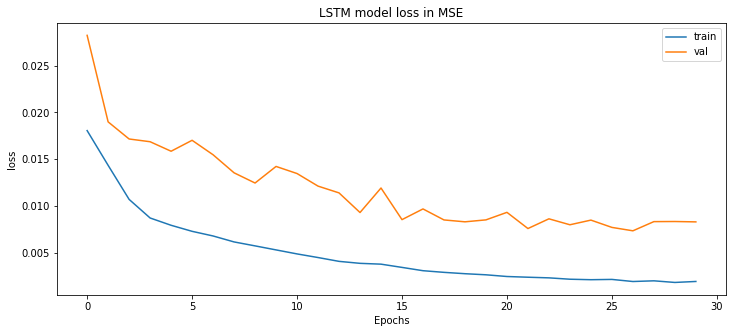

In [97]:
import matplotlib.pyplot as plt
loss_per_epoch = model.history.history['loss']
val_loss_per_epoch = model.history.history['val_loss']
plt.figure(figsize=(12,5))
plt.plot(loss_per_epoch);
plt.plot(val_loss_per_epoch);
plt.title("LSTM model loss in MSE");
plt.ylabel("loss");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

In [98]:
int(np.floor(len(df_copy)*(1-test_set_size)))

16217

In [99]:
y_pred = model.predict(X_test_lstm)
y_pred_rescaled = Target_scaler.inverse_transform(y_pred)

In [100]:
y_axis = list(df_new.index)[-854:]

In [102]:
from sklearn.metrics import r2_score, mean_squared_error
y_test_rescaled =  Target_scaler.inverse_transform(y_test_scaled)
score = r2_score(y_test_rescaled, y_pred_rescaled)
print('R-squared score for the test set: ', round(score,4))

R-squared score for the test set:  0.7314


In [103]:
y_actual = pd.DataFrame(y_test_rescaled, columns=['Actual'])
y_hat = pd.DataFrame(y_pred_rescaled, columns=['Predicted'])


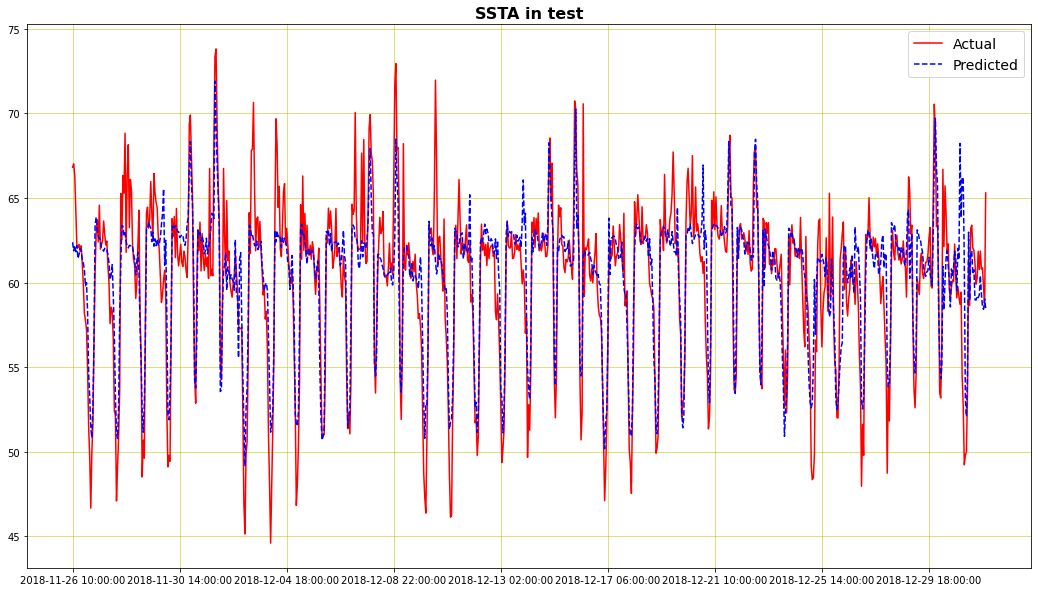

In [105]:
import datetime
positions = [0,100,200,300,400,500,600,700,800]
selected_labels = []
for i in positions:
  selected_labels.append(y_axis[i])

plt.figure(figsize=(18, 10))
plt.plot(y_actual, linestyle='solid', color='r')
plt.plot(y_hat, linestyle='dashed', color='b')
plt.xticks(positions, selected_labels)
plt.legend(['Actual','Predicted'], loc='best', prop={'size': 14})
plt.title('SSTA in test', weight='bold', fontsize=16)
plt.grid(color = 'y', linewidth='0.5')
plt.show()